## SAS Demo: Deep Learning on Superhero Product Images

### Table of contents
1. [Setup & Load Data](#casConnection)
2. [Explore Data](#exploreData)
3. [Prepare Data](#prepareData)
4. [Deep Learning Architecture](#dlArchitecture)
5. [Fit Deep Learning Model](#fitModel)
6. [Score Data](#scoreData)
7. [Model Deployment](#deployModel)
8. [Model Learning](#modelLearning)

### Setup Libraries and Load Data  <a name="casConnection"></a>

In [1]:
# Import Libraries
import swat
import sys
import matplotlib
import dlpy
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split
from dlpy.applications import *
import os
%matplotlib inline

In [2]:
# Create CAS Connection   
conn = swat.CAS(host, portnum, user, password)

In [3]:
# Set Image Training and Test Directories
train_data_dir = '/data/andre_data/SAS_Demo_Deep_Learning_Superhero_Classification/CAX_Superhero_Train/'

### Explore Superhero Training Dataset  <a name="exploreData"></a>

In [4]:
# Load Data into CAS
superTrain = ImageTable.load_files(conn, path=train_data_dir, casout={'name':'superTrain'})

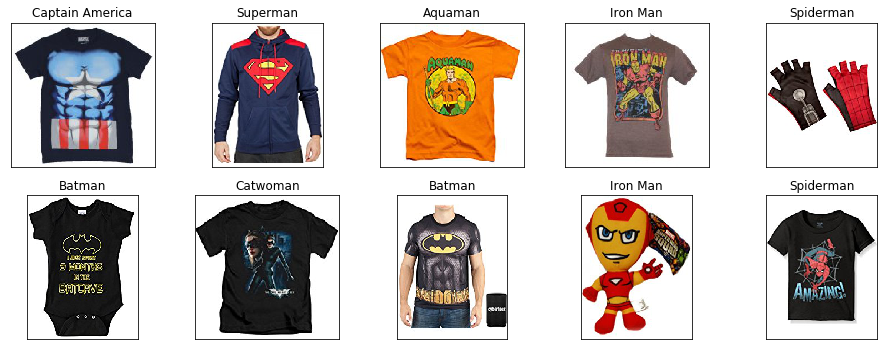

In [5]:
# Preview Images
superTrain.show(nimages=10, ncol=5, randomize=True)

In [6]:
# Label Frequency Table
superTrain.label_freq

,Level,Frequency
Ant-Man,1,241
Aquaman,2,201
Avengers,3,216
Batman,4,779
Black Panther,5,460
Captain America,6,410
Catwoman,7,200
Ghost Rider,8,200
Hulk,9,414
Iron Man,10,694


In [7]:
# View Count, Width, Height, Min, Max, and Mean
superTrain.image_summary

jpg                  5433
minWidth               73
maxWidth              540
minHeight             120
maxHeight             522
meanWidth         197.982
meanHeight        230.795
mean1stChannel    167.516
min1stChannel           0
max1stChannel         255
mean2ndChannel     166.33
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    173.753
min3rdChannel           0
max3rdChannel         255
dtype: object

### Prepare Data  <a name="prepareData"></a>

In [8]:
# Create Image 'Patches' to Increase Training Set
superTrainPatch = superTrain.as_patches(width=200,
                                        height=200,
                                        step_size=24,
                                        output_width=224,
                                        output_height=224,
                                        inplace=False)

In [9]:
# New Image 'Patches' from 5,433 to 98,150 Images
superTrainPatch.image_summary

jpg                 98150
minWidth              224
maxWidth              224
minHeight             224
maxHeight             224
meanWidth             224
meanHeight            224
mean1stChannel    157.374
min1stChannel           0
max1stChannel         255
mean2ndChannel    154.346
min2ndChannel           0
max2ndChannel         255
mean3rdChannel     163.43
min3rdChannel           0
max3rdChannel         255
dtype: object

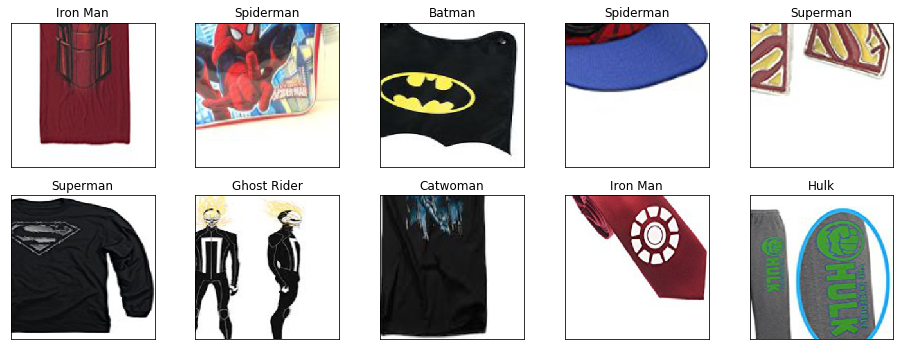

In [10]:
# Preview Perturbed Images
superTrainPatch.show(nimages=10, ncol=5, randomize=True)

In [11]:
# Split Training Data into Train / Test
trainData, testData = two_way_split(superTrainPatch, test_rate=20, seed=12345)

### Setup Deep Learning Architecture  <a name="dlArchitecture"></a>

In [12]:
# Pre-Trained Weights Directory Path
pre_trained_weights_path = '/data/images/'

In [13]:
# Use Popular VGG16 Model
model_vgg16 = VGG16(
    conn,
    model_table='VGG16_notop',
    n_classes=12,
    n_channels=3,
    width=224,
    height=224,
    scale=1,
    offsets=superTrainPatch.channel_means,
    pre_train_weight=True, 
    pre_train_weight_file=os.path.join(pre_trained_weights_path, 'VGG_ILSVRC_16_layers.caffemodel.h5'),
    include_top=False)

NOTE: Model table is attached successfully!
NOTE: Model is named to "vgg16_notop" according to the model name in the table.


In [14]:
model_vgg16.print_summary() # VGG16 b/c 16 Layers with Weights

*==================*===============*========*============*=================*======================*
|   Layer (Type)   |  Kernel Size  | Stride | Activation |   Output Size   | Number of Parameters |
*------------------*---------------*--------*------------*-----------------*----------------------*
| data(Input)      |     None      |  None  |    None    |  (224, 224, 3)  |        0 / 0         |
| conv1_1(Convo.)  |    (3, 3)     |   1    | Rectifier  | (224, 224, 64)  |      1728 / 64       |
| conv1_2(Convo.)  |    (3, 3)     |   1    | Rectifier  | (224, 224, 64)  |      36864 / 64      |
| pool1(Pool)      |    (2, 2)     |   2    |    Max     | (112, 112, 64)  |        0 / 0         |
| conv2_1(Convo.)  |    (3, 3)     |   1    | Rectifier  | (112, 112, 128) |     73728 / 128      |
| conv2_2(Convo.)  |    (3, 3)     |   1    | Rectifier  | (112, 112, 128) |     147456 / 128     |
| pool2(Pool)      |    (2, 2)     |   2    |    Max     |  (56, 56, 128)  |        0 / 0         |


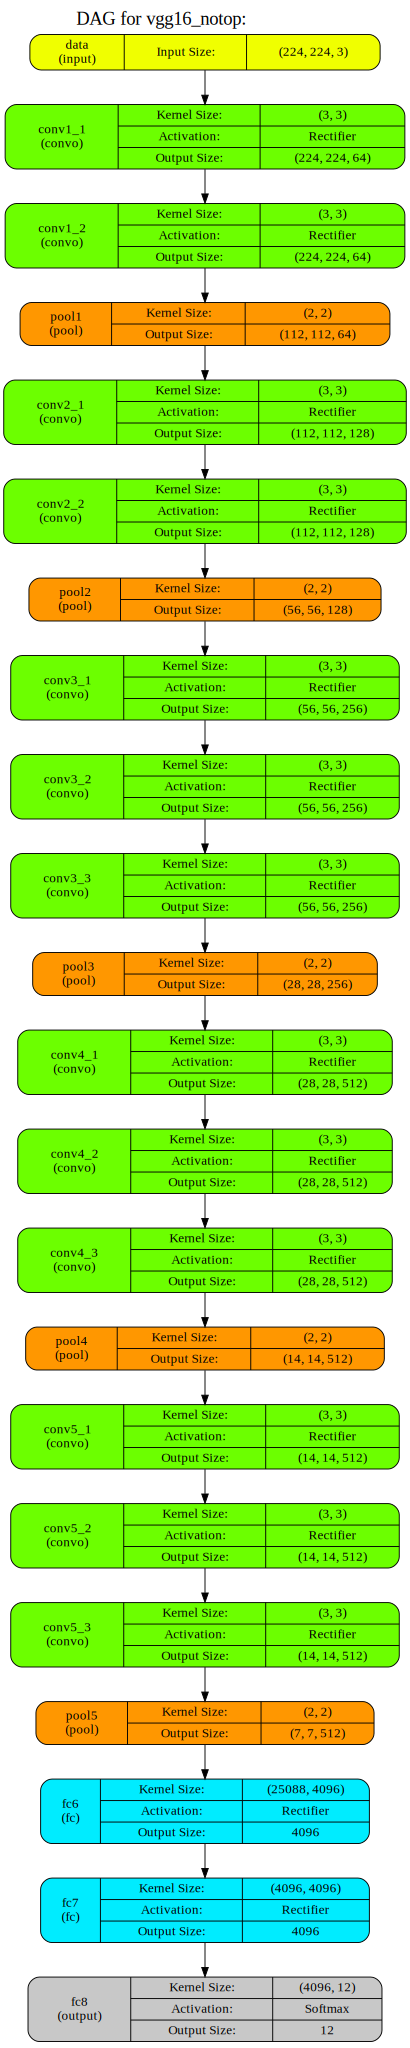

In [15]:
# Directed Acyclic Graph (DAG) of Popular VGG16 Model Architecture
model_vgg16.plot_network()

### Fit Deep Learning Model  <a name="fitModel"></a>

In [16]:
# Set Optimization and Algorithm Paramters
model_vgg16.fit(data=trainData,
                mini_batch_size=32,
                max_epochs=50,
                lr=0.001,
                gpu=dict(devices=[0,1,2,3]),
                nthreads=4,
                log_level=2);

NOTE: Training based on existing weights.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 134309708.
NOTE:  The approximate memory cost is 2093.00 MB.
NOTE:  Loading weights cost       0.21 (s).
NOTE:  Initializing each layer cost      11.75 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total number of minibatch size per thread on each worker is 32.
NOTE:  The maximum number of minibatch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:     12
NOTE:  Levels for the target variable:
NOTE:  Level      0: Catwoman       
NOTE:  Level      1: Iron Man       
NOTE:  Level      2: Hulk           
NOTE:  Level      3: Ant-Man        
NOTE:  Level      4: Aquaman        
NOTE:  Level      5: Spiderman      
NOTE:  Level      6: Superman       
NOTE:  Level      7: Black Panther  
NOTE:  Level      8: Captain America
NOTE:  Level      9: Ghost Rider 

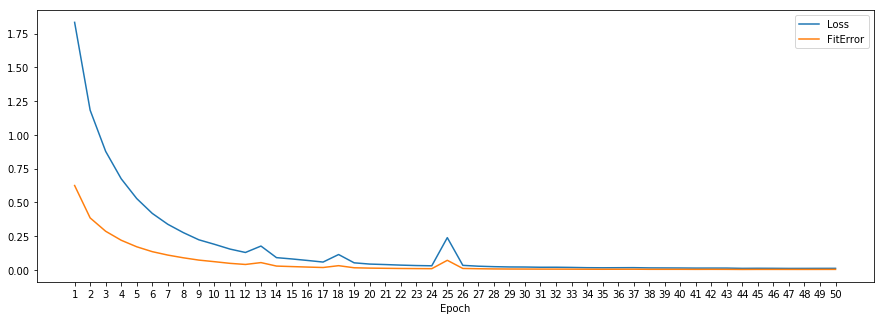

In [17]:
# Loss and Fit Error Over Epochs
model_vgg16.plot_training_history(items=('Loss', 'FitError'), fig_size=(15, 5))

### Score Test Data  <a name="scoreData"></a>

In [18]:
# Overall Training Error
model_vgg16.predict(data=testData, gpu=dict(devices=[0,1,2]))

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read         19629
 1  Number of Observations Used         19629
 2  Misclassification Error (%)      1.706659
 3                   Loss Error       0.06817

[OutputCasTables]

          casLib              Name   Rows  Columns  \
 0  CASUSER(sas)  Valid_Res_UD2NpQ  19629       19   
 
                                             casTable  
 0  CASTable('Valid_Res_UD2NpQ', caslib='CASUSER(s...

#### View Scored Image Examples

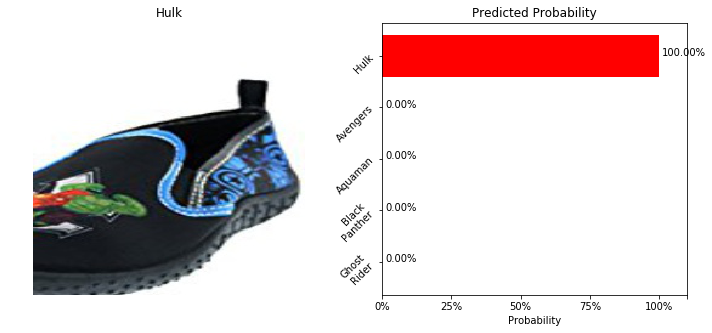

In [19]:
model_vgg16.plot_predict_res(image_id=1, type='C')

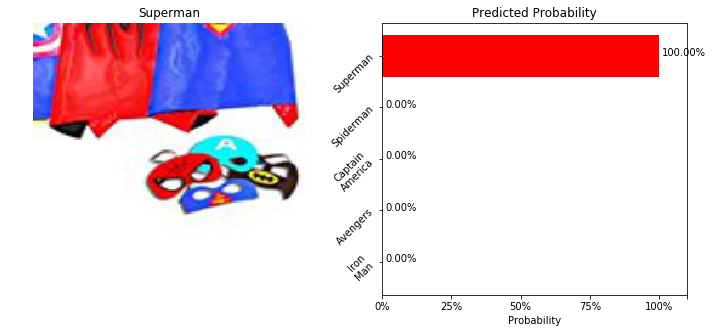

In [20]:
model_vgg16.plot_predict_res(image_id=2, type='C')

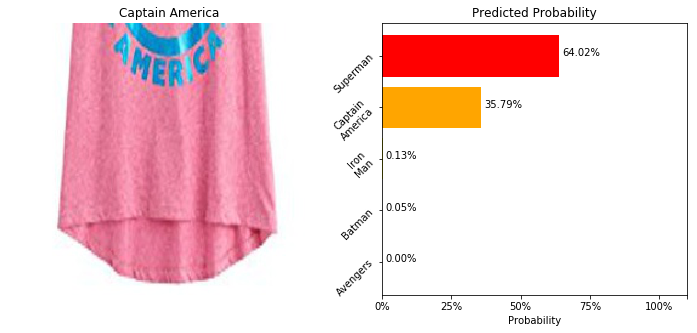

In [22]:
model_vgg16.plot_predict_res(image_id=0, type='M')

### Model Learning  <a name="modelLearning"></a>

#### Visualization through Heat Maps

Running prediction ...
... finished running prediction
NOTE: The number of images in the table is too large, only 5 randomly selected images are used in analysis.
NOTE: Table SAMPLE_TBL_NVHMTE contains compressed images.


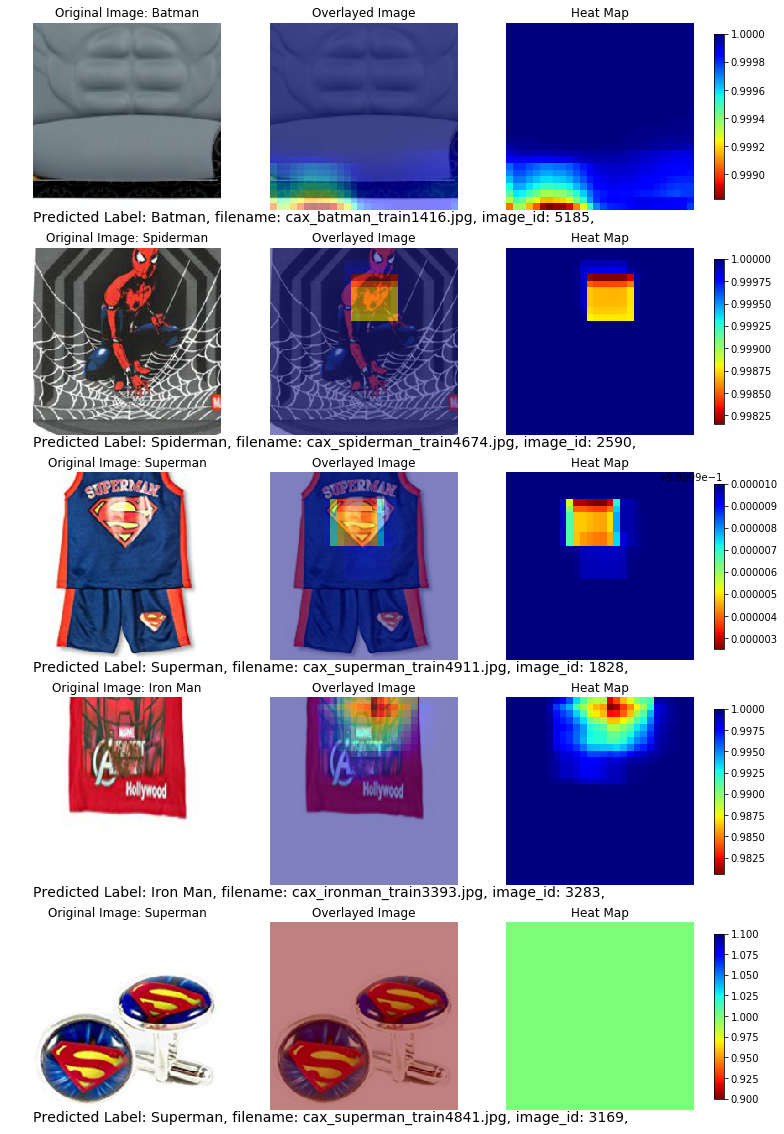

In [23]:
# Heat Map looks at individual pixels and looks at the impact of removing that pixel to the probability
#  of a correct classification
model_vgg16.heat_map_analysis(data=testData, mask_width=56, mask_height=56, step_size=8);

#### Visualization of Feature Maps

In [28]:
model_vgg16.get_feature_maps(data=testData, label='Iron Man', image_id=2)

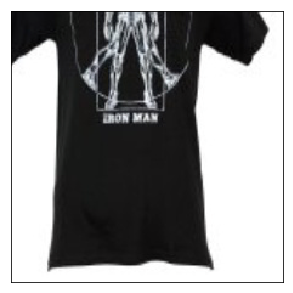

In [29]:
model_vgg16.feature_maps.display(layer_id=0)

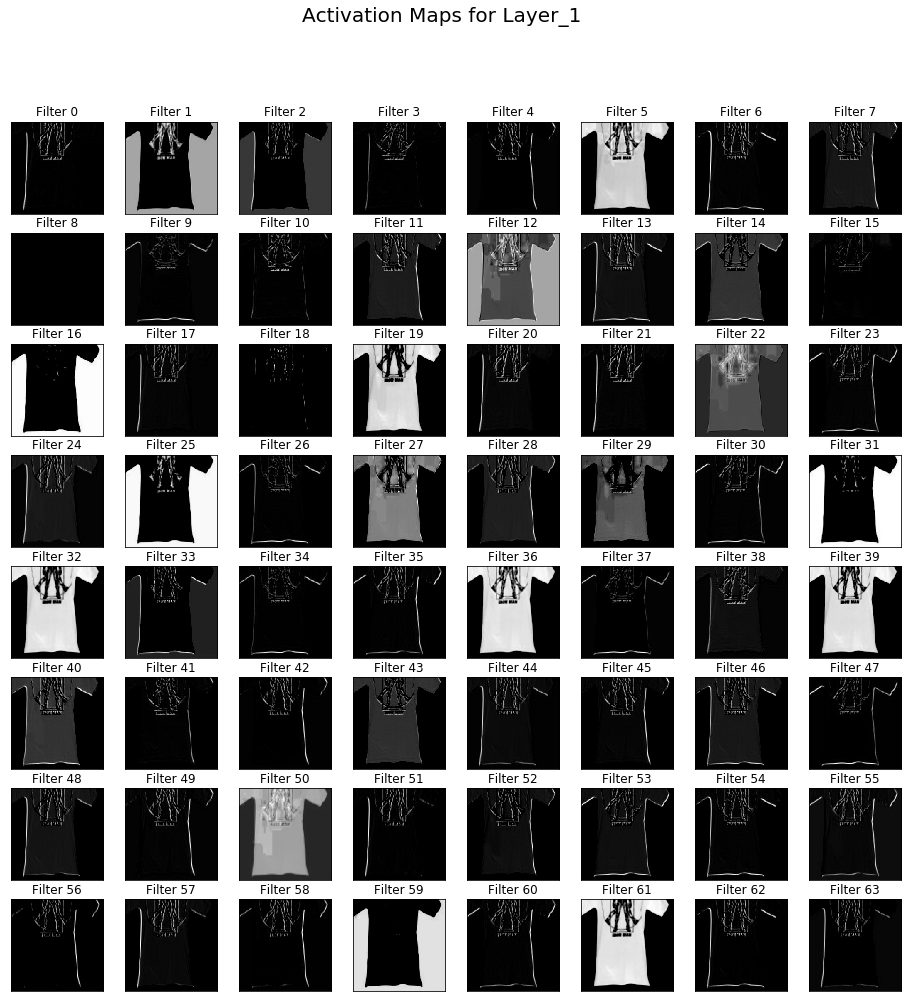

In [30]:
model_vgg16.feature_maps.display(layer_id=1)

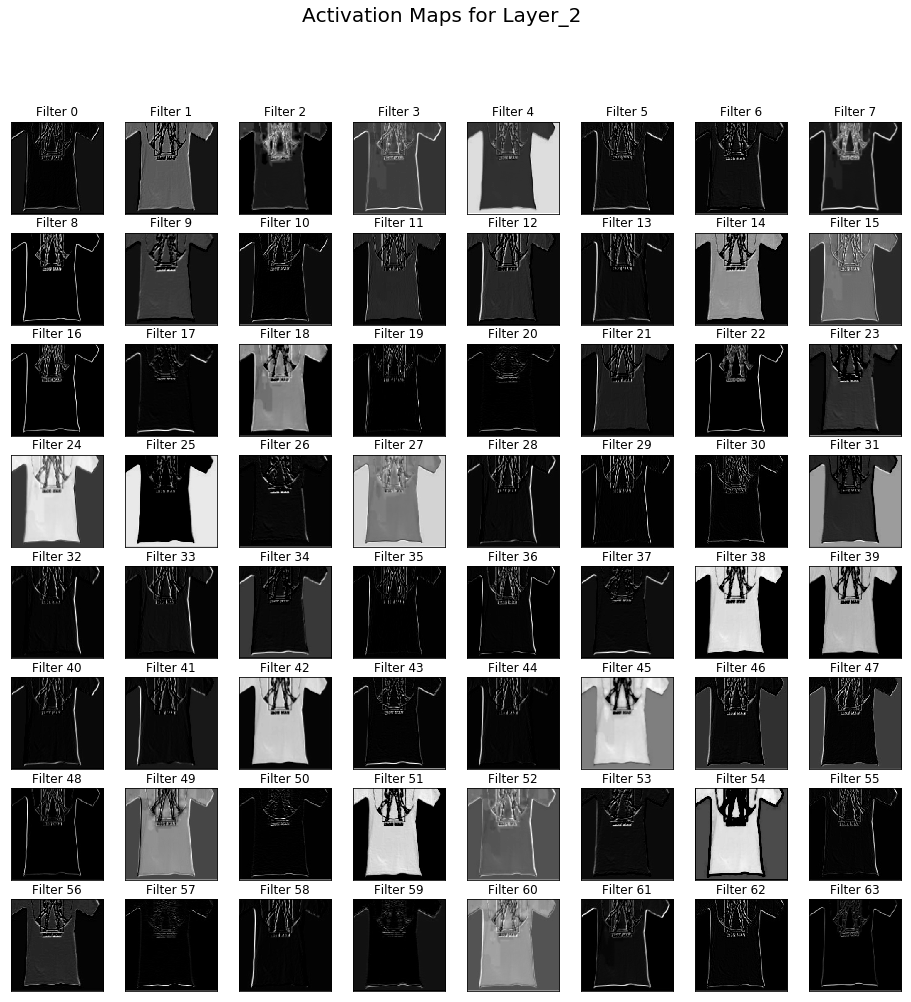

In [31]:
model_vgg16.feature_maps.display(layer_id=2)

### Model Deployment  <a name="deployModel"></a>

In [32]:
# Save Model as astore for Deployment
model_vgg16.deploy(path='/data/andre_data/SAS_Demo_Deep_Learning_Superhero_Classification/', output_format='astore')

NOTE: Model astore file saved successfully.


In [34]:
# Save Model (Architecture + Weights)
model_vgg16.save_to_table(path='/data/andre_data/SAS_Demo_Deep_Learning_Superhero_Classification/')

NOTE: Model table saved successfully.


Close Connection

In [40]:
conn.session.endsession()
conn.close()